# Image Segmentation using Full Connected Neural Network

By [Akshaj Verma](https://akshajverma.com)


This notebook takes you through an implementation of paper [Fully Convolutional Network for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf) on the Indian Driving Dataset.

In [1]:
import pathlib
from tqdm.notebook import tqdm

import cv2
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler


from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

Let's define the path for our data.

In [5]:
ROOT_PATH = "../../../data/computer_vision/image_segmentation/idd-lite/idd20k_lite/"
train_images_path = ROOT_PATH + "leftImg8bit/train/"
train_labels_path = ROOT_PATH + "gtFine/train/"


val_images_path = ROOT_PATH + "leftImg8bit/val/"
val_labels_path = ROOT_PATH + "gtFine/val/"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Visualize Data

### Training image

Shape of the image is:  (227, 320, 3) 




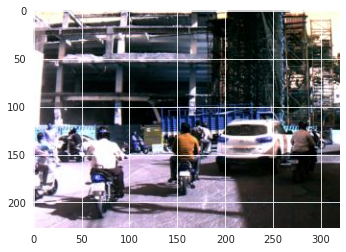

In [7]:
img = cv2.imread(train_images_path + "0/024541_image.jpg", 1)
print("Shape of the image is: ", img.shape, "\n\n")
plt.imshow(img)

### Histogram of image

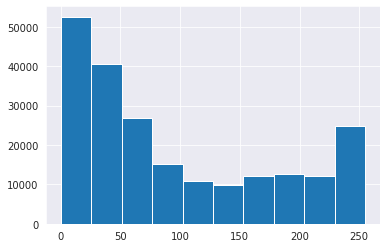

In [8]:
plt.hist(img.flatten())
plt.show()

### Training label

In [9]:
lol = Image.open(str(train_labels_path + "0/024541_label.png"))

In [10]:
np.array(lol)

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Shape of the label is:  (227, 320, 3) 




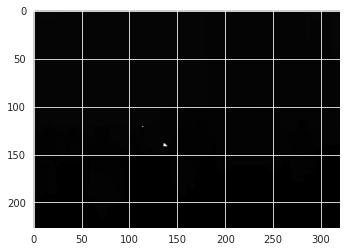

In [11]:
lbl = cv2.imread(train_labels_path + "0/024541_label.png", 1)
print("Shape of the label is: ", lbl.shape, "\n\n")
plt.imshow(lbl)

### Histogram of label

In [12]:
lbl_in_image = np.nonzero(np.bincount(lbl.flatten()))[0]
lbl_in_image

array([  0,   2,   3,   4,   5,   6, 255])

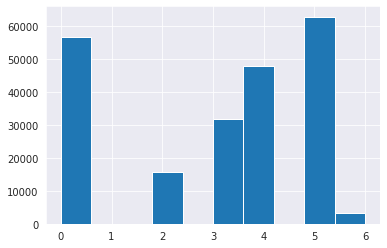

In [13]:
plt.hist(lbl.flatten(), range=[0, 6])
plt.show()

In [14]:
def enhance_seg_mask(img_path):
    img = cv2.imread(img_path, 0)
    img = img*41
    
    return img

In [15]:
enhanced_lbl = enhance_seg_mask(train_labels_path + "0/024541_label.png")
enhanced_lbl

array([[246, 246, 246, ..., 246, 246, 246],
       [246, 246, 246, ..., 246, 246, 246],
       [246, 246, 246, ..., 246, 246, 246],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

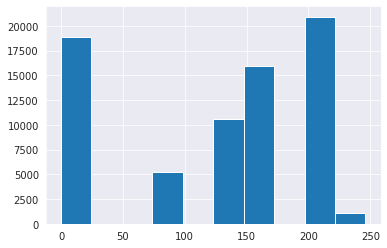

In [16]:
plt.hist(enhanced_lbl.flatten())
plt.show()

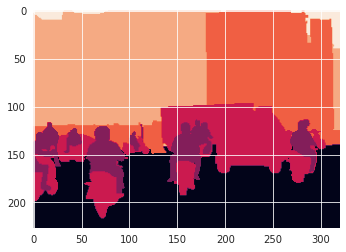

In [17]:
plt.imshow(enhanced_lbl)

## Data Preprocessing

### Create Transforms

In [18]:
IMAGE_LABEL_SIZE = 224

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMAGE_LABEL_SIZE, IMAGE_LABEL_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])
}

### Create Dataset

#### Path to data

In [19]:
root_path = pathlib.Path(ROOT_PATH)

print("Root path: ", root_path)
print("")

# train paths
train_images_path = root_path.joinpath("leftImg8bit").joinpath("train")
train_labels_path = root_path.joinpath("gtFine").joinpath("train")

print("Train Images path: ", train_images_path)
print("Train Labels path: ", train_labels_path)
print("")

# test paths
test_images_path = root_path.joinpath("leftImg8bit").joinpath("val")
test_labels_path = root_path.joinpath("gtFine").joinpath("val")

print("Test Images path: ", test_images_path)
print("Test Labels path: ",test_labels_path)
print("")

Root path:  /content/drive/My Drive/data/idd-lite/idd20k_lite

Train Images path:  /content/drive/My Drive/data/idd-lite/idd20k_lite/leftImg8bit/train
Train Labels path:  /content/drive/My Drive/data/idd-lite/idd20k_lite/gtFine/train

Test Images path:  /content/drive/My Drive/data/idd-lite/idd20k_lite/leftImg8bit/val
Test Labels path:  /content/drive/My Drive/data/idd-lite/idd20k_lite/gtFine/val



#### Base Dataset Class

In [20]:
class DatasetIDD(Dataset):
    def __init__(self, images_path, labels_path, image_transform, img_lbl_size):
        super(DatasetIDD, self).__init__()
        self.images_path = pathlib.Path(images_path)
        self.labels_path = pathlib.Path(labels_path)
        
        self.img_lbl_size = img_lbl_size
        self.transform = image_transform
        
        self.img_file_paths = [file for file in images_path.rglob("**/*.jpg")]
        self.lbl_file_paths = [file for file in labels_path.rglob("**/*.png") if len(file.parts[-1].split("_")) == 2 ]
        
    def __getitem__(self, idx):
        img_path = str(self.img_file_paths[idx])
        lbl_path = str(self.lbl_file_paths[idx])
        
        img = Image.open(img_path)
        img = self.transform(img)
        img = img[:, :224, :224]
        
        lbl = Image.open(lbl_path)
#         lbl = lbl.resize((self.img_lbl_size, self.img_lbl_size))
        lbl = torch.from_numpy(np.array(lbl)).long()[:224, :224]
        
        return img, lbl
    
    def __len__(self):
        return len(self.img_file_paths)

#### Train+Val Dataset

In [21]:
train_val_dataset = DatasetIDD(images_path=train_images_path, labels_path=train_labels_path, image_transform=image_transforms["train"], img_lbl_size=IMAGE_LABEL_SIZE)

#### Validation Dataset

We use `SubsetRandomSampler` to make our train and validation loaders. `SubsetRandomSampler` is used so that our each batch receives a random distribution of classes.

`SubsetRandomSampler(indices)` takes as input the indices of data.

We first create our samplers and then we'll pass it to our dataloaders.

* Create a list of indices.
* Shuffle the indices.
* Split the indices based on train-val percentage.
* Create SubsetRandomSampler.

Create a list of indices from 0 to length of dataset.

In [22]:
train_val_dataset_size = len(train_val_dataset)
train_val_dataset_indices = list(range(train_val_dataset_size))

Shuffle the list of indices using `np.shuffle`.

In [23]:
np.random.shuffle(train_val_dataset_indices)

Create the split index. We choose the split index to be 20% (0.2) of the dataset size.

In [24]:
val_split_index = int(np.floor(0.2 * train_val_dataset_size))

Slice the lists to obtain 2 lists of indices, one for train and other for test.

`0-----------val_split_index------------------------------n`

Train => val_split_index to n

Val => 0 to val_split_index

In [25]:
train_idx, val_idx = train_val_dataset_indices[val_split_index:], train_val_dataset_indices[:val_split_index]

Finally, create samplers.

In [26]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

#### Test Dataset

In [27]:
test_dataset = DatasetIDD(images_path=test_images_path, labels_path=test_labels_path, image_transform=image_transforms["test"], img_lbl_size=IMAGE_LABEL_SIZE)

### Create Dataloaders

In [28]:
train_loader = DataLoader(dataset=train_val_dataset, shuffle=False, batch_size=32, sampler = train_sampler)
val_loader = DataLoader(dataset=train_val_dataset, shuffle=False, batch_size=1, sampler = val_sampler)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

### Data Sanity Check

In [29]:
print("Shape of image from train-loader = ", next(iter(train_loader))[0].shape)
print("Shape of label from train-loader = ", next(iter(train_loader))[1].shape)

print("\nShape of image from val-loader = ", next(iter(val_loader))[0].shape)
print("Shape of label from val-loader = ", next(iter(val_loader))[1].shape)

print("\nShape of image from test-loader = ", next(iter(test_loader))[0].shape)
print("Shape of label from test-loader = ", next(iter(test_loader))[1].shape)

Shape of image from train-loader =  torch.Size([32, 3, 224, 224])
Shape of label from train-loader =  torch.Size([32, 224, 224])

Shape of image from val-loader =  torch.Size([1, 3, 224, 224])
Shape of label from val-loader =  torch.Size([1, 224, 224])

Shape of image from test-loader =  torch.Size([1, 3, 224, 224])
Shape of label from test-loader =  torch.Size([1, 224, 224])


## FCN Model

In [30]:
class ModelFCN8(nn.Module):
    def __init__(self, num_class):
        super(ModelFCN8, self).__init__()
        self.num_class = num_class
        
        self.block_1_1 = self.conv_block(c_in=3, c_out=64, kernel_size=3, stride=1, padding=1)
        self.block_1_2 = self.conv_block(c_in=64, c_out=64, kernel_size=3, stride=1, padding=1)
        
        self.block_2_1 = self.conv_block(c_in=64, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_2 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        self.block_2_3 = self.conv_block(c_in=128, c_out=128, kernel_size=3, stride=1, padding=1)
        
        self.block_3_1 = self.conv_block(c_in=128, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_2 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        self.block_3_3 = self.conv_block(c_in=256, c_out=256, kernel_size=3, stride=1, padding=1)
        
        self.block_4_1 = self.conv_block(c_in=256, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_4_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.block_5_1 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_2 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        self.block_5_3 = self.conv_block(c_in=512, c_out=512, kernel_size=3, stride=1, padding=1)
        
        self.conv1x1_512_4096 = nn.Conv2d(in_channels=512, out_channels=4096, kernel_size=1, stride=1, padding=0)
        
        
        self.conv1x1_4096_numclass = nn.Conv2d(in_channels=4096, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_512_numclass = nn.Conv2d(in_channels=512, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        self.conv1x1_256_numclass = nn.Conv2d(in_channels=256, out_channels=num_class, kernel_size=1, stride=1, padding=0)
        
        self.upsample_pool5_2x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=2, stride=2)
        self.upsample_pool4_2x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=2, stride=2)
        self.upsample_pool3_8x = nn.ConvTranspose2d(in_channels=num_class, out_channels=num_class, kernel_size=8, stride=8)
        
        self.final_conv = nn.Conv2d(in_channels=num_class, out_channels=num_class, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    
    def forward(self, x):
                              # 3 x 224 x 224
        x1 = self.block_1_1(x)
        x1 = self.block_1_2(x1)
        
        x1 = self.maxpool(x1) # 64 x 112 x 112
        
        x2 = self.block_2_1(x1)
        x2 = self.block_2_2(x2)
        x2 = self.block_2_3(x2)
        
        x2 = self.maxpool(x2) # 128 x 56 x 56
        
        x3 = self.block_3_1(x2)
        x3 = self.block_3_2(x3)
        x3 = self.block_3_3(x3)
        
        x3 = self.maxpool(x3) # 256 x 28 x 28
        p3 = self.conv1x1_256_numclass(x3) # 8 x 28 x 28
        
        x4 = self.block_4_1(x3)
        x4 = self.block_4_2(x4)
        x4 = self.block_4_3(x4)
        
        x4 = self.maxpool(x4) # 512 x 14 x 14
        p4 = self.conv1x1_512_numclass(x4) # 8 x 14 x 14
        
        x5 = self.block_5_1(x4)
        x5 = self.block_5_2(x5)
        x5 = self.block_5_3(x5) 
        
        x5 = self.maxpool(x5) # 512 x 7 x 7
        
        x5 = self.conv1x1_512_4096(x5) # 4096 x 7 x 7
        p5 = self.conv1x1_4096_numclass(x5) # 8 x 7 x 7
        
        
        # Upsampling using transposed convolutions
        o1 = self.upsample_pool5_2x(p5) # 8 x 14 x14
        o1 = o1 + p4
        o2 = self.upsample_pool4_2x(o1) # 8 x 28 x 28
        o2 = o2 + p3
        o3 = self.upsample_pool3_8x(o2) # 8 x 224 x 224
        
        
        output = self.final_conv(o3) # 8 x 224 x 224


        return output

        
    def conv_block(self, c_in, c_out, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU()
        )
        
        return seq_block

In [31]:
model = ModelFCN8(num_class=8)
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

ModelFCN8(
  (block_1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, 

In [32]:
loss_stats = {
    'train': [],
    "val": []
}

In [33]:
EPOCHS = 300

In [34]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                                    
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += train_loss.item()

    
    if e%5 == 0:
        model_name = "model_idd_seg_fcn8_" + str(e)
        torch.save(model, model_name)
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
                        
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 01: | Train Loss: 1.55389 | Val Loss: 1.38072
Epoch 02: | Train Loss: 1.07563 | Val Loss: 0.89125
Epoch 03: | Train Loss: 1.02484 | Val Loss: 1.08986
Epoch 04: | Train Loss: 1.00984 | Val Loss: 1.02315


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ModelFCN8. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 05: | Train Loss: 1.00141 | Val Loss: 1.13033
Epoch 06: | Train Loss: 0.98491 | Val Loss: 0.83953
Epoch 07: | Train Loss: 0.97798 | Val Loss: 0.73933
Epoch 08: | Train Loss: 0.99884 | Val Loss: 1.22958
Epoch 09: | Train Loss: 0.98864 | Val Loss: 0.97480
Epoch 10: | Train Loss: 0.97990 | Val Loss: 0.80491
Epoch 11: | Train Loss: 0.97728 | Val Loss: 0.84526
Epoch 12: | Train Loss: 0.98524 | Val Loss: 1.00701
Epoch 13: | Train Loss: 0.98129 | Val Loss: 0.90575
Epoch 14: | Train Loss: 0.98089 | Val Loss: 0.97299
Epoch 15: | Train Loss: 0.97637 | Val Loss: 1.08769
Epoch 16: | Train Loss: 0.97814 | Val Loss: 1.06426
Epoch 17: | Train Loss: 0.97851 | Val Loss: 1.21188
Epoch 18: | Train Loss: 0.97232 | Val Loss: 0.78614
Epoch 19: | Train Loss: 0.98477 | Val Loss: 1.02340
Epoch 20: | Train Loss: 0.96839 | Val Loss: 0.81926
Epoch 21: | Train Loss: 0.96452 | Val Loss: 0.91490
Epoch 22: | Train Loss: 0.96326 | Val Loss: 0.74930
Epoch 23: | Train Loss: 0.97231 | Val Loss: 0.95438
Epoch 24: | 

In [36]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_tag = y_pred_tag
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [37]:
total_iou = 0

for i in range(len(y_pred_list)):
    temp_iou = jaccard_score(y_true_list[i].squeeze().flatten(), y_pred_list[i].squeeze().flatten(), average="macro")
    total_iou += temp_iou

In [38]:
print("Cumulative IOU = ", total_iou/len(y_pred_list))

Cumulative IOU =  0.21204808062756514


In [39]:
def array_to_img_for_viz(arr):
    arr = arr * 41
    arr = arr.squeeze()
    arr = np.uint8(arr)
    arr_img = Image.fromarray(arr)
    
    return arr_img  

Text(0.5, 1.0, 'Predicted Mask')

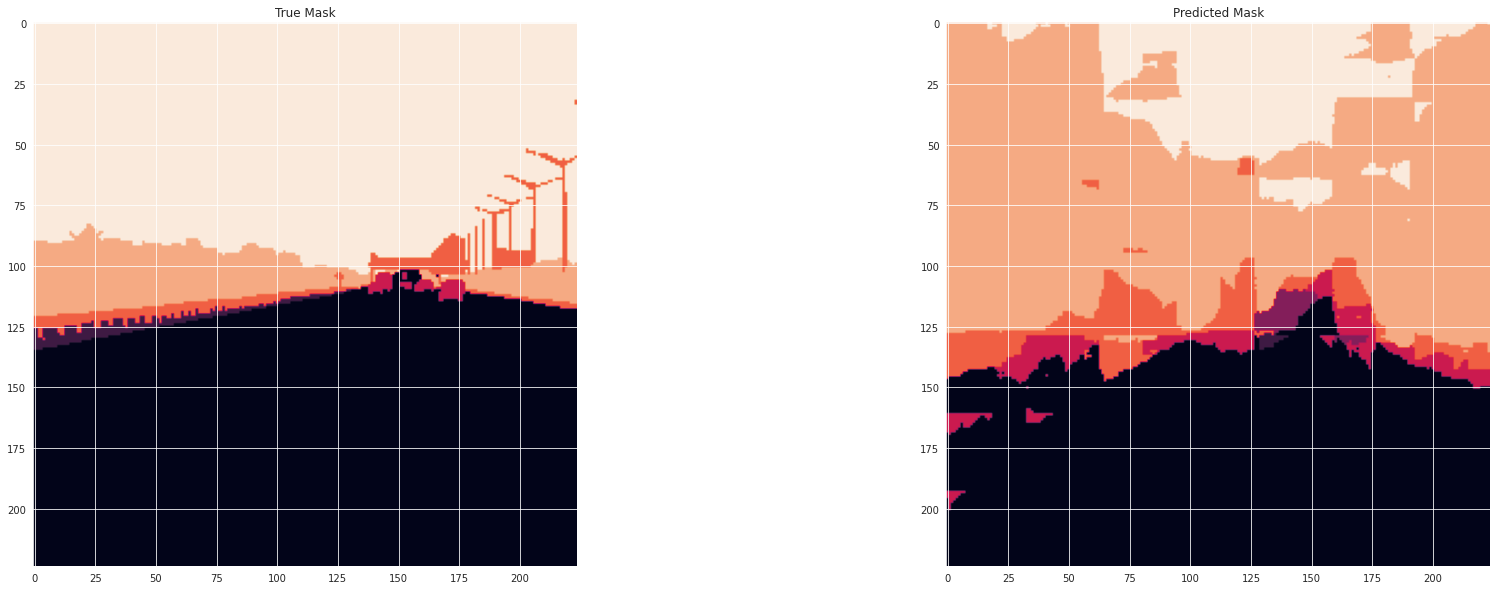

In [68]:
image_index_to_view = 42


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].imshow(array_to_img_for_viz(y_true_list[image_index_to_view]))
axes[0].set_title("True Mask")
axes[1].imshow(array_to_img_for_viz(y_pred_list[image_index_to_view]))
axes[1].set_title("Predicted Mask")